In [1]:
from geomagio.edge import EdgeFactory
from geomagio.algorithm import Algorithm
from obspy.core import UTCDateTime, Stream,  Stats
import numpy as np
import scipy as sp
import scipy.linalg as spl
import scipy.signal as sps
import matplotlib.pyplot as pl
import datetime as dt
import json

In [2]:
class FilterAlgorithm(Algorithm):
    """Filter Algorithm"""

In [3]:
# excerpted from https://github.com/scipy/scipy/issues/7725#issuecomment-322094749
sample_rate = 10.0
cutoff = 0.2
width = 0.3
stop_db = 50.0
stop_db = np.abs(stop_db)

# Convert to normalized frequencies
nyq = 0.5*sample_rate
cutoff = cutoff / nyq
width = width / nyq

numtaps, beta = sps.kaiserord(ripple=stop_db, width=width)
numtaps |= 1
taps = sps.firwin(numtaps, cutoff, window=('kaiser', beta), scale=False)

In [4]:
numtaps

99

In [5]:
beta

4.533514120981248

In [6]:
taps

array([-4.52198796e-05, -1.11619355e-04, -2.01483397e-04, -3.16506684e-04,
       -4.57626335e-04, -6.24859943e-04, -8.17155093e-04, -1.03225668e-03,
       -1.26659826e-03, -1.51522326e-03, -1.77174156e-03, -2.02832596e-03,
       -2.27575221e-03, -2.50348516e-03, -2.69981225e-03, -2.85202413e-03,
       -2.94664077e-03, -2.96967983e-03, -2.90696256e-03, -2.74445127e-03,
       -2.46861053e-03, -2.06678395e-03, -1.52757659e-03, -8.41232992e-04,
        8.97254861e-19,  1.00153625e-03,  2.16614984e-03,  3.49372106e-03,
        4.98103797e-03,  6.62166161e-03,  8.40586129e-03,  1.03206248e-02,
        1.23497468e-02,  1.44739951e-02,  1.66713562e-02,  1.89173528e-02,
        2.11854322e-02,  2.34474143e-02,  2.56739920e-02,  2.78352727e-02,
        2.99013480e-02,  3.18428788e-02,  3.36316814e-02,  3.52413005e-02,
        3.66475558e-02,  3.78290461e-02,  3.87676015e-02,  3.94486690e-02,
        3.98616244e-02,  4.00000000e-02,  3.98616244e-02,  3.94486690e-02,
        3.87676015e-02,  

In [7]:
sum(taps)

1.0034504636745052

In [8]:
taps=taps/sum(taps)

In [9]:
taps

array([-4.50643866e-05, -1.11235541e-04, -2.00790576e-04, -3.15418344e-04,
       -4.56052742e-04, -6.22711300e-04, -8.14345224e-04, -1.02870717e-03,
       -1.26224294e-03, -1.51001301e-03, -1.76564925e-03, -2.02135136e-03,
       -2.26792681e-03, -2.49487668e-03, -2.69052868e-03, -2.84221717e-03,
       -2.93650846e-03, -2.95946829e-03, -2.89696669e-03, -2.73501420e-03,
       -2.46012197e-03, -2.05967711e-03, -1.52232387e-03, -8.38340329e-04,
        8.94169561e-19,  9.98092368e-04,  2.15870132e-03,  3.48170755e-03,
        4.96391018e-03,  6.59889237e-03,  8.37695691e-03,  1.02851364e-02,
        1.23072809e-02,  1.44242249e-02,  1.66140301e-02,  1.88523036e-02,
        2.11125840e-02,  2.33667880e-02,  2.55857094e-02,  2.77395583e-02,
        2.97985293e-02,  3.17333839e-02,  3.35160355e-02,  3.51201198e-02,
        3.65215396e-02,  3.76989672e-02,  3.86342953e-02,  3.93130209e-02,
        3.97245562e-02,  3.98624560e-02,  3.97245562e-02,  3.93130209e-02,
        3.86342953e-02,  

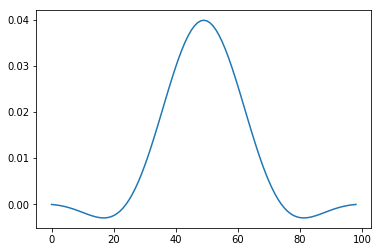

In [10]:
pl.plot(taps)

In [24]:
taps2 = sps.firwin2(99, freq=[0, 0.2, 0.5, 1.0], gain=[0, 0.1, -50, -100], nyq=1.0)

In [25]:
taps2

array([ 8.14655296e-04, -4.88496571e-04,  2.47779380e-04, -6.97162361e-04,
       -2.32774642e-04, -1.70497700e-03,  3.62563309e-04,  8.25168359e-05,
        1.99279698e-03, -2.00925634e-04,  2.72560013e-03,  2.00171435e-04,
        8.92520500e-04, -5.58570542e-03, -1.19015530e-03, -4.07222950e-03,
        1.51424738e-03, -4.09568224e-03,  8.82481077e-03,  5.53343473e-03,
        1.16809072e-02, -6.95661341e-03,  3.41798666e-03, -1.24754116e-02,
       -5.31625820e-03, -2.98922022e-02,  5.68526557e-03,  2.13981829e-03,
        3.47979706e-02, -8.35061312e-04,  4.62549002e-02,  3.96166432e-03,
        1.30966319e-02, -9.37730238e-02, -2.38806794e-02, -7.21394330e-02,
        2.48170724e-02, -7.17521764e-02,  1.75363781e-01,  1.22870189e-01,
        2.72272349e-01, -1.73284321e-01,  9.48255174e-02, -4.59548774e-01,
       -2.68274135e-01, -1.89051302e+00,  5.33500777e-01,  4.60504162e-01,
        2.37892232e+01, -4.49762268e+01,  2.37892232e+01,  4.60504162e-01,
        5.33500777e-01, -

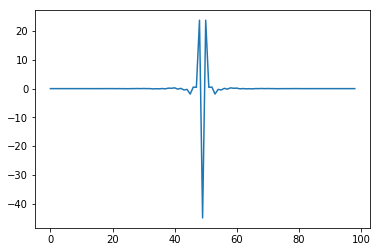

In [26]:
pl.plot(taps2)

In [14]:
w, h = sps.freqz(taps2)

/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


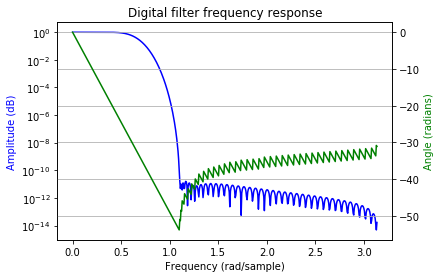

In [15]:
fig = pl.figure()
pl.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)
pl.semilogy(w, np.abs(h), 'b')
pl.ylabel('Amplitude (dB)', color='b')
pl.xlabel('Frequency (rad/sample)')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
pl.plot(w, angles, 'g')
pl.ylabel('Angle (radians)', color='g')
pl.grid()
pl.axis('tight')
pl.show()

In [11]:
w = linspace(0.0,np.pi,512)
gd_samples = (numtaps/2 - 1)*ones_like(w)
gd_time = (numtaps/2 - 1)
gd_

NameError: name 'linspace' is not defined

In [46]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='butter')

In [47]:
a

array([2.94794932e-09, 2.06356452e-08, 6.19069356e-08, 1.03178226e-07,
       1.03178226e-07, 6.19069356e-08, 2.06356452e-08, 2.94794932e-09])

In [48]:
b

array([  1.        ,  -6.43513372,  17.7687487 , -27.28864598,
        25.17318559, -13.94787923,   4.29785921,  -0.56813419])

In [85]:
ts = np.asarray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y = np.asarray([0, 0, 0, 0, 0, 0, 0, 0])

In [57]:
tout, yout = sps.dimpulse((a,b,0.1), t=np.arange(0,99,0.1))

In [58]:
tout

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

In [51]:
yout

(array([[ 2.94794932e-09],
        [ 3.96060933e-08],
        [ 2.64396071e-07],
        [ 1.18129713e-06],
        [ 4.01358323e-06],
        [ 1.11587968e-05],
        [ 2.66326925e-05],
        [ 5.64174864e-05],
        [ 1.08660984e-04],
        [ 1.93701617e-04],
        [ 3.23916056e-04],
        [ 5.13401949e-04],
        [ 7.77519340e-04],
        [ 1.13232135e-03],
        [ 1.59390845e-03],
        [ 2.17774164e-03],
        [ 2.89794922e-03],
        [ 3.76665894e-03],
        [ 4.79338394e-03],
        [ 5.98448654e-03],
        [ 7.34273901e-03],
        [ 8.86699534e-03],
        [ 1.05519834e-02],
        [ 1.23882219e-02],
        [ 1.43620611e-02],
        [ 1.64558455e-02],
        [ 1.86481877e-02],
        [ 2.09143458e-02],
        [ 2.32266888e-02],
        [ 2.55552376e-02],
        [ 2.78682631e-02],
        [ 3.01329264e-02],
        [ 3.23159424e-02],
        [ 3.43842520e-02],
        [ 3.63056839e-02],
        [ 3.80495940e-02],
        [ 3.95874653e-02],
 

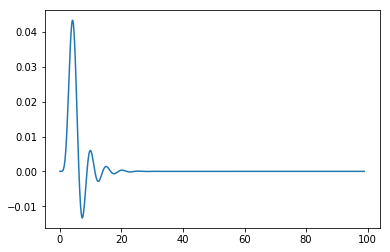

In [52]:
pl.plot(tout, yout[0])

In [101]:
tbout, bout = sps.dlsim((a,b,0.1),t=np.append(tout,np.arange(99,199,0.1)) ,u=np.append((np.flip(yout[0],0)),(yout[0][-1]*np.ones_like(np.arange(99,199,0.1)))))

In [102]:
tbout

array([0.00000000e+00, 1.00050302e-01, 2.00100604e-01, ...,
       1.98699899e+02, 1.98799950e+02, 1.98900000e+02])

In [103]:
bout

array([[-1.40720618e-22],
       [-2.00251656e-21],
       [-1.42042184e-20],
       ...,
       [-4.73992765e-14],
       [-4.91453138e-14],
       [-5.07749201e-14]])

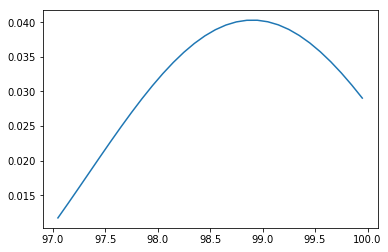

In [121]:
pl.plot(tbout[970:1000],bout[970:1000])

In [105]:
np.max(bout)

0.04028381793551497

In [106]:
np.where(bout==np.max(bout))

(array([989]), array([0]))

In [117]:
filt2 = bout[989-99:989+98]

In [118]:
filt2

array([[-3.00869288e-04],
       [-4.45641762e-04],
       [-5.91481095e-04],
       [-7.36066637e-04],
       [-8.76963144e-04],
       [-1.01165372e-03],
       [-1.13757602e-03],
       [-1.25216124e-03],
       [-1.35287558e-03],
       [-1.43726345e-03],
       [-1.50299200e-03],
       [-1.54789623e-03],
       [-1.57002404e-03],
       [-1.56768041e-03],
       [-1.53947007e-03],
       [-1.48433779e-03],
       [-1.40160548e-03],
       [-1.29100549e-03],
       [-1.15270908e-03],
       [-9.87349619e-04],
       [-7.96039594e-04],
       [-5.80380941e-04],
       [-3.42468088e-04],
       [-8.48832612e-05],
       [ 1.89316336e-04],
       [ 4.76619718e-04],
       [ 7.73091844e-04],
       [ 1.07441189e-03],
       [ 1.37591994e-03],
       [ 1.67267189e-03],
       [ 1.95950204e-03],
       [ 2.23109302e-03],
       [ 2.48205215e-03],
       [ 2.70699358e-03],
       [ 2.90062512e-03],
       [ 3.05783874e-03],
       [ 3.17380345e-03],
       [ 3.24405935e-03],
       [ 3.2

In [119]:
w, h = sps.freqz(filt2)

/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


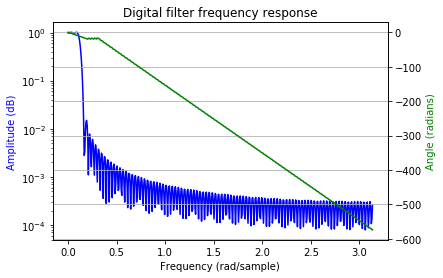

In [120]:
fig = pl.figure()
pl.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)
pl.semilogy(w, np.abs(h), 'b')
pl.ylabel('Amplitude (dB)', color='b')
pl.xlabel('Frequency (rad/sample)')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
pl.plot(w, angles, 'g')
pl.ylabel('Angle (radians)', color='g')
pl.grid()
pl.axis('tight')
pl.show()

In [86]:
ts_imp = sps.filtfilt(a=a,b=b,x=ts)

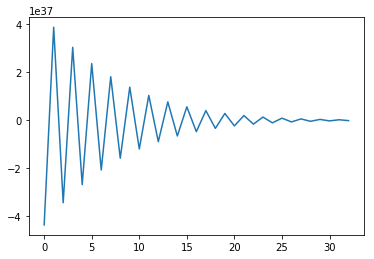

In [87]:
pl.plot(ts_imp)

In [89]:
np

AttributeError: module 'numpy' has no attribute 'epsilon'

In [15]:
w, gd = sps.group_delay((a,b))

/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/scipy/signal/filter_design.py:536: UserWarning: The group delay is singular at frequencies [3.074, 3.080, 3.086, 3.093, 3.099, 3.105, 3.111, 3.117, 3.123, 3.129, 3.135], setting to 0
  format(", ".join("{0:.3f}".format(ws) for ws in w[singular]))


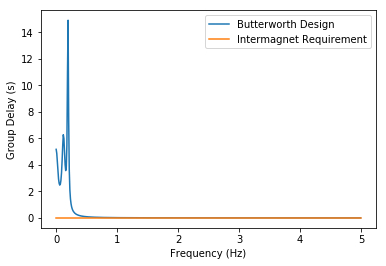

In [22]:
pl.plot(w*sample_rate/2/np.pi, gd/sample_rate, w*sample_rate/2/np.pi, 0.01*np.ones_like(w))
pl.xlabel('Frequency (Hz)')
pl.ylabel('Group Delay (s)')
pl.legend(('Butterworth Design', 'Intermagnet Requirement'))

In [23]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='cheby1')

In [24]:
w, gd = sps.group_delay((a,b))

/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/scipy/signal/filter_design.py:536: UserWarning: The group delay is singular at frequencies [3.129, 3.135], setting to 0
  format(", ".join("{0:.3f}".format(ws) for ws in w[singular]))


In [25]:
a

array([5.92719812e-08, 2.96359906e-07, 5.92719812e-07, 5.92719812e-07,
       2.96359906e-07, 5.92719812e-08])

In [20]:
b

array([ 1.        , -4.9082771 ,  9.65633587, -9.51809429,  4.70039227,
       -0.93035486])

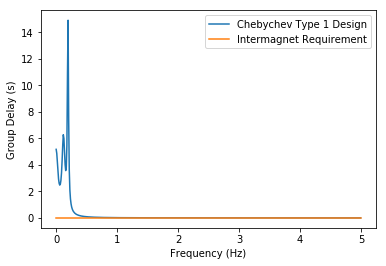

In [21]:
pl.plot(w*sample_rate/2/np.pi, gd/sample_rate, w*sample_rate/2/np.pi, 0.01*np.ones_like(w))
pl.xlabel('Frequency (Hz)')
pl.ylabel('Group Delay (s)')
pl.legend(('Chebychev Type 1 Design', 'Intermagnet Requirement'))

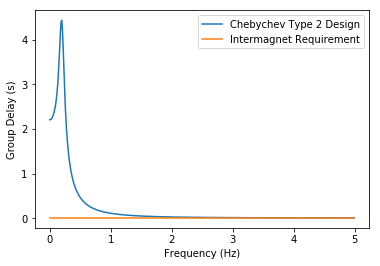

In [17]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='cheby2')
w, gd = sps.group_delay((a,b))
pl.plot(w*sample_rate/2/np.pi, gd/sample_rate, w*sample_rate/2/np.pi, 0.01*np.ones_like(w))
pl.xlabel('Frequency (Hz)')
pl.ylabel('Group Delay (s)')
pl.legend(('Chebychev Type 2 Design', 'Intermagnet Requirement'))

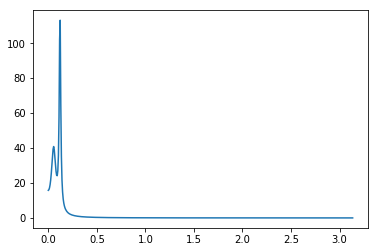

In [18]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='ellip')
w, gd = sps.group_delay((a,b))
pl.plot(w,gd)

In [19]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='bessel')
w, gd = sps.group_delay((a,b))
pl.plot(w,gd)

ValueError: bessel does not have order selection. Use iirfilter function.

In [160]:
200000/(2.0**24)

0.011920928955078125

In [18]:
w.shape

(512,)

In [20]:
a = EdgeFactory(cwbhost="166.154.45.158", host="166.154.45.158")

In [26]:
temp = a.get_timeseries(channels=['UK2'], starttime=UTCDateTime("2018-09-11T21:45:00Z"), endtime=UTCDateTime("2018-09-11T21:50:00Z"), observatory="GXX", type="variation", interval="minute")

In [27]:
temp

1 Trace(s) in Stream:
NT.GXX.R0.UK2 | 2018-09-11T21:44:54.240000Z - 2018-09-11T21:49:53.640000Z | 59.9 s, 6 samples

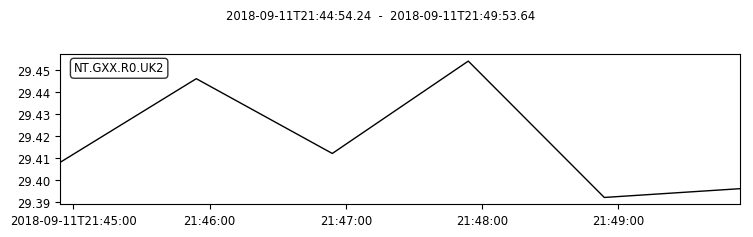

In [28]:
temp.plot()

In [29]:
b = temp[0]

In [30]:
b.times()

array([  0.  ,  59.88, 119.76, 179.64, 239.52, 299.4 ])

In [31]:
1/60

0.016666666666666666

In [32]:
c = EdgeFactory()

In [39]:
brt = c.get_timeseries(channels=['UK1'], starttime=UTCDateTime("2018-09-11T21:45:00Z"), endtime=UTCDateTime("2018-09-11T21:50:00Z"), observatory="BRT", type="variation", interval="minute")

read_wave_server_v returned flag FR - requested data right (later) than tank contents


In [34]:
brt[0].times()

array([  0.  ,  59.88, 119.76, 179.64, 239.52, 299.4 ])

In [40]:
dht = c.get_timeseries(channels=['MVH'], starttime=UTCDateTime("2018-09-10T21:45:00Z"), endtime=UTCDateTime("2018-09-10T21:50:00Z"), observatory="DHT", type="variation", interval="minute")

In [41]:
dht[0].times()

array([  0.,  60., 120., 180., 240., 300.])